In [1]:
import datetime
import json
import os
from pathlib import Path
import random
import subprocess
from osgeo import gdal, osr
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from pyproj import Transformer
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    MimeType,
    SentinelHubRequest,
    SHConfig,
    bbox_to_dimensions,
)
from shapely.geometry import Point
from collections import defaultdict

In [2]:
def plot_image(image, factor=1, clip_range=(0, 1)):
    # Apply factor to image
    image = image * factor

    # Clip image values
    image = image.clip(clip_range[0], clip_range[1])

    # Plot the image
    plt.imshow(image)
    plt.show()

In [3]:
# will fetch the lon-lats at center of each county from the file state_county_lon_lats.csv

archive_dir = Path("ML-ARCHIVES--v01/")
scll = archive_dir / "state_county_lon_lat.csv"

df_scll = pd.read_csv(scll).drop(["lon", "lat"], axis=1)
print(df_scll.head())

  state_name county_name
0   COLORADO     LARIMER
1   COLORADO       LOGAN
2   COLORADO      MORGAN
3   COLORADO    SEDGWICK
4   COLORADO        WELD


In [4]:
county_dir = Path("COUNTY-BOUNDING-POLYGONS/")
if not county_dir.exists():
    county_dir.makedirs(exist_ok=True)
county_file = "cb_2022_us_county_20m.dbf"
county_path = county_dir / county_file

# Load county boundary data from Shapefile
counties = gpd.read_file(county_path)

In [8]:
def create_lon_lat_seqs(df_scll, counties, count):
    df_scll['STATE_NAME'] = df_scll['state_name'].apply(lambda x: x.title())
    df_scll['NAME'] = df_scll['county_name'].apply(lambda x: x.title())
    # df_scll.index.difference(counties.index)
    broken_counties = [('Illinois', 'De Kalb'),
                ('Illinois',      'La Salle'),
                ('Illinois',     'Mcdonough'),
                ('Illinois',       'Mchenry'),
                ('Illinois',        'Mclean'),
                ('Illinois',      'St Clair'),
                ( 'Indiana',       'De Kalb'),
                ( 'Indiana',      'La Porte'),
                ( 'Indiana',      'Lagrange'),
                (    'Iowa',       'O Brien'),
                (  'Kansas',     'Mcpherson'),
                ('Missouri',    'St Charles'),
                ('Missouri',      'St Louis'),
                ('Missouri', 'Ste Genevieve')]
    fixed_counties = [
        ('Illinois',          'DeKalb',   'DeKalb'),
                ('Illinois',      'Salle', ""),
                ('Illinois',     'Mcdonough', ""),
                ('Illinois',       'Mchenry', ""),
                ('Illinois',        'Mclean', ""),
                ('Illinois',      'St. Clair', ""),
                ( 'Indiana',       'DeKalb', ""),
                ( 'Indiana',      'LaPorte', ""),
                ( 'Indiana',      'Lagrange', ""),
                (    'Iowa',       'Brien', ""),
                (  'Kansas',     'Mcpherson', ""),
                ('Missouri',    'St. Charles', ""),
                ('Missouri',      'St. Louis', ""),
                ('Missouri', 'Ste. Genevieve', "")]
    for (br_state, br_county), (state, county, new_county) in zip(broken_counties, fixed_counties):
        
        sery = counties[(counties.STATE_NAME == state) & (counties.NAME.str.contains(county, case=False))][["STATE_NAME", "NAME"]]
        df_scll.loc[(df_scll.STATE_NAME == br_state) & (df_scll.NAME == br_county), ["STATE_NAME", "NAME"]] = [sery["STATE_NAME"].iloc[0], sery["NAME"].iloc[0]]
        if len(sery) == 0:
            print(county, sery)
    df_scll = df_scll.set_index(["STATE_NAME", "NAME"])
    counties = counties.set_index(["STATE_NAME", "NAME"])
    j_counties = counties.join(df_scll, on=["STATE_NAME", "NAME"], how='inner')
    assert len(df_scll.index.difference(counties.index)) == 0
    j_counties["points"] = j_counties.sample_points(size=count)
    samples = j_counties["points"].to_dict()
    seq_lat_lon = defaultdict(lambda: defaultdict(list))
    for (state, county), points in samples.items():
        seq_lat_lon[state][county] =  [ (p.x, p.y) for p in points.geoms ]
    return seq_lat_lon, j_counties


print(datetime.datetime.now())
seq_lat_lon, j_counties = create_lon_lat_seqs(df_scll, counties, 5000)
print(datetime.datetime.now())


# <span style=color:blue>Save dict as json  </span>

out_file = archive_dir / "state_county__seq_of_lon_lats.json"

with out_file.open("w") as fp:
    json.dump(seq_lat_lon, fp)



2023-06-06 10:01:58.198373
2023-06-06 10:03:27.282756


In [82]:
from ipyleaflet import Map, GeoData, basemaps, LayersControl
import geopandas
import json

countries = gpd.GeoDataFrame(geometry=[j_counties.unary_union], crs=j_counties.crs)#.plot(alpha=0.5, edgecolor="k")

m = Map(center=(52.3,8.0), zoom = 3, basemap= basemaps.Esri.WorldTopoMap)

geo_data = GeoData(geo_dataframe = countries,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Countries')

m.add_layer(geo_data)
# m.add_layer(gpd.GeoDataFrame(geometry=[j_counties.unary_union.envelope], crs=j_counties.crs))
# m.add_control(LayersControl())

m

Map(center=[52.3, 8.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

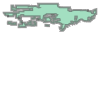

In [92]:
gpd.GeoDataFrame(geometry=[j_counties.unary_union], crs=j_counties.crs)

In [93]:
from shapely.ops import unary_union
boundary = gpd.GeoSeries(unary_union(j_counties.unary_union))

In [95]:
j_counties.unary_union.bounds

(-106.190554078709, 35.995812, -80.518893, 43.500885)

In [11]:
def make_grid(polygon, edge_size):
    """
    polygon : shapely.geometry
    edge_size : length of the grid cell
    """
    from itertools import product
    import numpy as np
    import geopandas as gpd
    
    bounds = polygon.bounds
    x_coords = np.arange(bounds[0] + edge_size/2, bounds[2], edge_size)
    y_coords = np.arange(bounds[1] + edge_size/2, bounds[3], edge_size)
    combinations = np.array(list(product(x_coords, y_coords)))
    squares = gpd.points_from_xy(combinations[:, 0], combinations[:, 1]).buffer(edge_size / 2, cap_style=3)
    return gpd.GeoSeries(squares[squares.intersects(polygon)])


In [162]:
grid = make_grid(j_counties.points.unary_union, 0.2)
countries = gpd.GeoDataFrame(geometry=grid, crs=j_counties.crs)#.plot(alpha=0.5, edgecolor="k")

m = Map(center=(52.3,8.0), zoom = 3, basemap= basemaps.Esri.WorldTopoMap)

geo_data = GeoData(geo_dataframe = countries,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Countries')

m.add_layer(geo_data)
m

Map(center=[52.3, 8.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

In [7]:

#!/usr/bin/env python
# coding: utf-8

# ## <span style=color:blue>This notebook builds the function soy_is_here(year,lat,lon), which produces "True" if the 100m x 100m area around lon-lat was a soybean field in the given year.  (At least, according to the data of USDA NASS.)  </span>
#
# ## <span style=color:blue>Then we import the dictionary with the lon-lat sequences for each county, and for each year find the first 20 that are in soybean fields, and right

# <span style=color:blue>First step is to create a function that tests, given a year-lon-lat triple, whether there was a soy field at lat-lon during the given year.  This is based on checking files downloaded from https://www.nass.usda.gov/Research_and_Science/Cropland/Release/index.php.  To understand the meaning of the pixel values, please see https://www.nass.usda.gov/Research_and_Science/Cropland/metadata/meta.php and the files in there, e.g., https://www.nass.usda.gov/Research_and_Science/Cropland/metadata/metadata_ia22.htm.  Among other things, you will see that the value of '5' corresponds to soybean fields </span>

# first, examining the structure of the files I downloaded

dir_main = Path("CROPSCAPE/DATA-DOWNLOADS/")
dir_main.mkdir(parents=True, exist_ok=True)


# following the structure of the directory name and file from downloaded zip files, which are organized by year
def pathname_for_year(year):
    last_dir_name = f"{str(year)}_30m_cdls/"
    file_name = f"{str(year)}_30m_cdls.tif"
    return dir_main / last_dir_name / file_name

def dataset_for_year(year):
    dataset = rasterio.open(str(pathname_for_year(year)))
    return dataset

# test
print(pathname_for_year(2022))
# <span style=color:blue>Now we inspect structure of the tif files.     </span>
#
# #### <span style=color:blue>Note that the Coordinate Reference System (CRS) is EPSG: 5070 rather than EPSG:4326 (also basically equivalent to WGS84), which is the one we are often using.  BTW, the unit of measure for EPSG:5070 is 1 meter, and so the pixels in these tif files are approximately 30m x 30m.  (See https://epsg.io/5070-1252) </span>


def pull_useful_gdal(dataset):
    useful = {}

    # Get raster band count
    useful["band_count"] = dataset.RasterCount

    # Get size
    useful["size"] = [dataset.RasterXSize, dataset.RasterYSize]

    # Get corner coordinates
    geotransform = dataset.GetGeoTransform()
    useful["proj:transform"] = geotransform
    x_size = dataset.RasterXSize
    y_size = dataset.RasterYSize

    corners = {
        "upperLeft": [geotransform[0], geotransform[3]],
        "lowerLeft": [geotransform[0], geotransform[3] + geotransform[5] * y_size],
        "upperRight": [geotransform[0] + geotransform[1] * x_size, geotransform[3]],
        "lowerRight": [
            geotransform[0] + geotransform[1] * x_size,
            geotransform[3] + geotransform[5] * y_size,
        ],
    }

    # Compute center coordinates
    corners["center"] = [
        (corners["upperLeft"][0] + corners["lowerRight"][0]) / 2,
        (corners["upperLeft"][1] + corners["lowerRight"][1]) / 2,
    ]
    useful["cornerCoordinates"] = corners

    # Define the source and target spatial references
    src_srs = osr.SpatialReference()
    src_srs.ImportFromWkt(dataset.GetProjection())
    print("Dataset project", dataset.GetProjection())

    tgt_srs = osr.SpatialReference()
    tgt_srs.ImportFromEPSG(4326)  # 4326  # WGS84 #  , 8826

    # Set up a coordinate transformation
    transform = osr.CoordinateTransformation(src_srs, tgt_srs)

    # Get corner coordinates and reproject them
    corners_projected = {}
    for name, coords in [
        ("upperLeft", (0, 0)),
        ("lowerLeft", (0, dataset.RasterYSize)),
        ("upperRight", (dataset.RasterXSize, 0)),
        ("lowerRight", (dataset.RasterXSize, dataset.RasterYSize)),
    ]:
        x, y = gdal.ApplyGeoTransform(geotransform, *coords)
        lon, lat, _ = transform.TransformPoint(x, y)
        corners_projected[name] = [lon, lat]
    useful["cornerCoordinatesProj"] = corners_projected

    # Get bounding box
    # bbox = {
    #     'west_longitude': min(corners_projected['upperLeft'][0], corners_projected['lowerLeft'][0], corners_projected['upperRight'][0], corners_projected['lowerRight'][0]),
    #     'north_latitude': max(corners_projected['upperLeft'][1], corners_projected['lowerLeft'][1], corners_projected['upperRight'][1], corners_projected['lowerRight'][1]),
    #     'east_longitude': max(corners_projected['upperLeft'][0], corners_projected['lowerLeft'][0], corners_projected['upperRight'][0], corners_projected['lowerRight'][0]),
    #     'south_latitude': min(corners_projected['upperLeft'][1], corners_projected['lowerLeft'][1], corners_projected['upperRight'][1], corners_projected['lowerRight'][1])
    # }
    bbox = {
        "west_longitude": corners_projected["upperLeft"][0],
        "north_latitude": corners_projected["upperLeft"][1],
        "east_longitude": corners_projected["lowerRight"][0],
        "south_latitude": corners_projected["lowerRight"][1],
    }
    useful["bbox"] = bbox
    bbox = {
        "west_longitude": corners["upperLeft"][0],
        "north_latitude": corners["upperLeft"][1],
        "east_longitude": corners["lowerRight"][0],
        "south_latitude": corners["lowerRight"][1],
    }
    useful["bbox_noproj"] = bbox

    # Get EPSG code
    useful["espgEncoding"] = int(src_srs.GetAuthorityCode(None))

    return useful


def pull_useful(
    ginfo,
):  # should give as input the result.stdout from calling gdalinfo -json
    useful = {}
    useful["band_count"] = len(ginfo["bands"])
    useful["cornerCoordinates"] = ginfo["cornerCoordinates"]
    useful["proj:transform"] = ginfo["stac"]["proj:transform"]
    useful["size"] = ginfo["size"]
    useful["bbox"] = ginfo["stac"]["proj:projjson"]["bbox"]
    useful["espgEncoding"] = ginfo["stac"]["proj:epsg"]
    return useful


path_to_file = pathname_for_year(2008)
# path_to_file = pathname_for_year(2022)
# dataset = gdal.Open(str(path_to_file))
# useful_gdal = pull_useful_gdal(dataset)
gdalInfoReq = " ".join(["gdalinfo", "-json", str(path_to_file)])

result = subprocess.run([gdalInfoReq], shell=True, capture_output=True, text=True)

print()


print(result.stderr)
gdalInfo = json.loads(result.stdout)

useful = pull_useful(gdalInfo)
with open("gdal_process.json", "w") as outfile:
    json.dump(useful, outfile, indent=2, sort_keys=True)
# with open("gdal_lib.json", "w") as outfile:
    # json.dump(useful_gdal, outfile, indent=2, sort_keys=True)
# exit()


# <span style=color:blue>Function to transform from EPSG:4326 to EPSG:5070.  The rasterio-based function we use below will take coordinates in EPSG:5010, since the tif files we are using here are in EPSG:5010.     </span>

transformer = Transformer.from_crs("EPSG:4326", "EPSG:5070")


def from_4326_to_5070(lon, lat):
    # I'm not sure why the role positions of lon-lat are different on input and output
    # but that is what my numerous small test runs showed to me
    new_lon, new_lat = transformer.transform(lat, lon)
    return new_lon, new_lat


# test on coordinates from central Iowa
# old_lon = -92.8
# old_lat = 42.7
# print(from_4326_to_5070(old_lon, old_lat))
# (you can check this at https://epsg.io/transform)
# <span style=color:blue>Function that fetches a 3x3 square of pixel values from the given tif file.  The pixels in the tif file correspond to  30m x 30m, so we are looking at a rouhgly 100m x 100m area that is all or mostly soybean field </span>
#
# <span style=color:blue>Note that in 2008 the target area was planted mainly with maize, but in 2022 it was planted with soybeans</span>


# expects lon-lat to be in EPSG:4326.
# These are converted to EPSG:5070 inside the function
def get_coordinate_pixels(dataset, lon, lat):
    lon_new, lat_new = from_4326_to_5070(lon, lat)

    py, px = dataset.index(lon_new, lat_new)

    # create 3px x 3px window centered on the lon-lat
    window = rasterio.windows.Window(px - 1, py - 1, 3, 3)
    clip = dataset.read(window=window)
    return clip


# test
# old_lon = -92.8
# old_lat = 42.7
# path_to_file = pathname_for_year(2008)
# print(get_coordinate_pixels(path_to_file, old_lon, old_lat))
# print()
# path_to_file = pathname_for_year(2022)
# print(get_coordinate_pixels(path_to_file, old_lon, old_lat))
# <span style=color:blue>Also, a function that that tests whether all 9 spots in the 3x3 square have a given value.  (We are interested in "5", which is soy beans.)</span>


# land_use_val should be an integer; see, e.g.,
#     https://www.nass.usda.gov/Research_and_Science/Cropland/metadata/metadata_ia22.htm
#     for mapping from values to meanings
def usage_is_here(dataset, lon, lat, land_use_val):
    arr = get_coordinate_pixels(dataset, lon, lat)
    out = True
    for i in range(0, 3):
        for j in range(0, 3):
            out = out & (arr[0][i][j] == land_use_val)
    return out


def soy_is_here(dataset, lon, lat):
    return usage_is_here(dataset, lon, lat, 5) # 1 is corn, 5 is soy

def corn_is_here(dataset, lon, lat):
    return usage_is_here(dataset, lon, lat, 1) # 1 is corn, 5 is soy

# old_lon = -92.8
# old_lat = 42.7
# print(corn_is_here(2008, old_lon, old_lat))
# print(corn_is_here(2022, old_lon, old_lat))
# ### <span style=color:blue>Importing the dictionary with lon-lat sequences.  Also setting a second dict that will hold lists lon-lats that are in soybean fields.</span>

# <span style=color:blue>Function that scans through one list of lon-lats and finds first set that are in soybean fields</span>


def gen_corn_lon_lats(dataset, year, state, county, count):
    points = seq_lat_lon[state][county]
    i = 0
    out_list = []
    for ll in points:
        if corn_is_here(dataset, ll[0], ll[1]):
            out_list += [ll]
            i += 1
        if i == 20:
            return out_list, []
    print(
        f"\nFor {str(year)}, {state}, {county}: \nFailed to find {str(count)} lon-lats that were in corn fields. Found only {str(i)}.\n"
    )
    short_fall_record = [year, state, county, i]
    return out_list, short_fall_record


# corn_lat_lons, short = gen_corn_lon_lats(dataset_for_year(2008), 2008, "ILLINOIS", "MASSAC", 20)
# print(corn_lat_lons)
# print(short)
# print()
# list, short = gen_soy_lon_lats(2008, "MISSOURI", "DALLAS", 20)
# print(list)
# print(short)
# <span style=color:blue>Function that generates a fixed number of lon-lats in soybean fields for each year and each county. This took quite a while to run completely -- about 4 hours.    </span>

working_dir = Path("OUTPUTS/OUTPUT-v01/")
working_dir.mkdir(parents=True, exist_ok=True)
dict1_file = working_dir / "year_state_county_corn_seq.json"
short_list = working_dir / "year_state_county_shortfalls.json"


def gen_all_corn_lists(corn_lat_lons, count):
    dict1 = {}
    for year in range(2008, 2023):
        dict1[year] = {}
        for key in corn_lat_lons.keys():
            dict1[year][key] = {}
    print(dict1.keys())
    print(dict1[2013].keys())

    shortfall_list = []

    i = 0
    for year in dict1.keys():
        dataset = dataset_for_year(year)
        for state in corn_lat_lons.keys():
            for county in corn_lat_lons[state].keys():
                points, short = gen_corn_lon_lats(dataset, year, state, county, count)
                dict1[year][state][county] = points
                if short != []:
                    shortfall_list += [short]

                i += 1
                if i % 20 == 0:
                    print(
                        f"Have generated corn lon-lat lists for {str(i)} year-county pairs"
                    )
                if i % 50 == 0:
                    with dict1_file.open("w") as fp:
                        json.dump(dict1, fp)
                    with short_list.open("w") as fp:
                        json.dump(shortfall_list, fp)

    return dict1, shortfall_list


print(datetime.datetime.now())
dict1, short = gen_all_corn_lists(seq_lat_lon, 20)
print(datetime.datetime.now())
# <span style=color:blue>Save the dict1 and also the shortfalls    </span>

dict1_file = archive_dir / "year_state_county_corn_seq.json"
short_list = archive_dir / "year_state_county_shortfalls.json"

with dict1_file.open("w") as fp:
    json.dump(dict1, fp)
with short_list.open("w") as fp:
    json.dump(short, fp)
# <span style=color:blue>Collecting year-state-county with zero hits </span>

zero_falls = []

for l in short:
    if l[3] == 0:
        zero_falls += [[l]]

print(len(zero_falls))

print(json.dumps(zero_falls, indent=4))

zero_file = archive_dir / "year_state_county_corn_zero_falls.json"
with zero_file.open("w") as fp:
    json.dump(zero_falls, fp)
# <span style=color:blue>Checking if any year-state-county in zero_falls had a positive yield in year_state_county_yield table</span>

yscy_file = archive_dir / "year_state_county_yield.csv"

df_yscy = pd.read_csv(yscy_file)
print("Top of df_yscy")
print(df_yscy.head())

zero_with_yield = []
for l in zero_falls:
    year = l[0][0]
    state = l[0][1]
    county = l[0][2]
    rows = df_yscy[
        (df_yscy["year"] == year)
        & (df_yscy["state_name"] == state)
        & (df_yscy["county_name"] == county)
    ]
    if len(rows) > 0:
        y = rows["yield"].iloc[0]
        zero_with_yield += [
            {"year": year, "state_name": state, "county_name": county, "yield": y}
        ]

print("\nLength of zero_with_yield is: ", len(zero_with_yield))
print("\nListing of zero_with_yield")
df_zwy = pd.DataFrame(zero_with_yield)
print(df_zwy.head(30))

zero_with_yield = archive_dir / "year_state_county_soy_zero_with_yield.csv"
df_zwy.to_csv(zero_with_yield, index=False)
# <span style=color:blue>For this exercise, we will drop these year-state-county triples from consideration.  A more thorough approach would be to focus on these year-state-county pairs (and perhaps the other ones with < 20 lon-lats), and randomly generate more lon-lats within the county until at least a few are found inside soybean fields.  (On the one hand, there have to be some if there was a yield ... however, CropScape is not perfect and may not have identified them accurately.)</span>


CROPSCAPE/DATA-DOWNLOADS/2022_30m_cdls/2022_30m_cdls.tif


2023-06-05 16:44:33.779082
dict_keys([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])
dict_keys(['Illinois', 'Iowa', 'Indiana', 'Kansas', 'Nebraska', 'Ohio', 'Missouri', 'Colorado'])
Have generated corn lon-lat lists for 20 year-county pairs
Have generated corn lon-lat lists for 40 year-county pairs
Have generated corn lon-lat lists for 60 year-county pairs
Have generated corn lon-lat lists for 80 year-county pairs
Have generated corn lon-lat lists for 100 year-county pairs
Have generated corn lon-lat lists for 120 year-county pairs
Have generated corn lon-lat lists for 140 year-county pairs
Have generated corn lon-lat lists for 160 year-county pairs
Have generated corn lon-lat lists for 180 year-county pairs
Have generated corn lon-lat lists for 200 year-county pairs
Have generated corn lon-lat lists for 220 year-county pairs
Have generated corn lon-lat lists for 240 year-county pairs

In [5]:
%env SENTINEL_CLIENT_ID=0d67f2dd-b15f-4a0d-a504-143db1f4b0f7
%env SENTINEL_CLIENT_SECRET=!{nz6Re26F{>uQ2RP;h/eDuR|V%;7]hGB27.xa#W

env: SENTINEL_CLIENT_ID=0d67f2dd-b15f-4a0d-a504-143db1f4b0f7
env: SENTINEL_CLIENT_SECRET=!{nz6Re26F{>uQ2RP;h/eDuR|V%;7]hGB27.xa#W


In [6]:

#!/usr/bin/env python
# coding: utf-8

# ## <span style=color:blue>In this notebook, we illustrate how to get the NDVI value for a single cell of size roughly 100m x 100m.  This will give you the basic machinery needed to gather sequences of NDVI values that can be incorporated into your ML pipelines   </span>

# ### <span style=color:blue>First, we create function that retrieves the NVDI for a given year, week, and 100m x 100m cell centered at some lon-lat   </span>

# <span style=color:blue>To get started with accessing SentinelHub using Python, I found the site https://sentinelhub-py.readthedocs.io/en/latest/index.html to be helpful.  In particular, you can find and download the SentinelHub-py github repository at https://github.com/sentinel-hub/sentinelhub-py, and then work through some of the Examples.</span>
#
# <span style=color:blue>First, we set up access to SentinelHub</span>

# To access SentinelHub you need a client_id and client_secret.
# To get your own access to SentinelHub, go
#    to https://docs.sentinel-hub.com/api/latest/api/overview/authentication/.
#    From there you can get a user name and password for a free 30-day trial.
#    Once you sign in, find you way to
#    https://apps.sentinel-hub.com/dashboard/, and from the
#    "User Settings" area you can create an OAuth client -- this will give you
#    a Client_ID and a Client_Secret.  (I had to create a couple of these in order
#    to get one that worked.  Also, they do expire after a while...)
# I put my client_ID and client_secret into some environment variables

SENTINEL_CLIENT_ID = os.getenv("SENTINEL_CLIENT_ID")
SENTINEL_CLIENT_SECRET = os.environ.get("SENTINEL_CLIENT_SECRET")
# <span style=color:blue>Now create a client for accessing SentinelHub     </span>

config = SHConfig()

# using third client id and secret, from 2023-05-26
config.sh_client_id = SENTINEL_CLIENT_ID
config.sh_client_secret = SENTINEL_CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print(
        "Warning! To use Process API, please provide the credentials (OAuth client ID and client secret)."
    )
else:
    print("Successfully set up SentinelHub client")
# <span style=color:blue> Not sure why sentinelhub examples include this next cell, but I will blindly imitate them   </span>


# <span style=color:blue>Importing useful things from SentinelHub  </span>

# The following is not a package. It is a file utils.py which should be in the same
#     folder as this notebook.
# As a slight variation, I have cloned the sentinelhub-py repo into my local github,
#     and grab utils.py from there
# ### <span style=color:blue>As a small warm-up exercise, to help you get familiar with accessing data from SentinalHub, here is an example of pulling some RGB data and viewing it     </span>
#
# <span style=color:blue> First, identifying a couple of bounding boxes to work with. Note that the second example is focusing on a single cell with size about 100m x 100m. </span>

# convenient site for finding lat/long coordinates:
#     http://bboxfinder.com/#0.000000,0.000000,0.000000,0.000000

# Bounding box containing the 7 soybean states of interest is as follows:
# [-104.370117,35.782171,-79.628906,48.048710]
# However, this is too big of a region to request in one call to SentinelHub

# Bounding box for about 1/8 of Iowa
# [-96.481934,42.520700,-95.075684,43.516689]


Successfully set up SentinelHub client


In [9]:
j_counties.set_geometry("points")

STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID   
STATE_NAME NAME                                                        
Illinois   Massac       17      127  01784730  0500000US17127  17127  \
           Kendall      17      093  00424248  0500000US17093  17093   
Iowa       Iowa         19      095  00465236  0500000US19095  19095   
Indiana    Greene       18      055  00451676  0500000US18055  18055   
           Miami        18      103  00450373  0500000US18103  18103   
...                    ...      ...       ...             ...    ...   
Iowa       Dubuque      19      061  00465219  0500000US19061  19061   
Ohio       Geauga       39      055  01074040  0500000US39055  39055   
           Clark        39      023  01074024  0500000US39023  39023   
Nebraska   Morrill      31      123  00835883  0500000US31123  31123   
Illinois   Mason        17      125  00424261  0500000US17125  17125   

                          NAMELSAD STUSPS LSAD       ALAND    AWATER   
STATE_NAME NAME                                                        
Illinois   Massac    Massac County     IL   06   614218330  12784614  \
           Kendall  Kendall County     IL   06   829412771   5136525   
Iowa       Iowa        Iowa County     IA   06  1518911690   2686847   
Indiana    Greene    Greene County     IN   06  1404983953   8919619   
           Miami      Miami County     IN   06   968246954   9184623   
...                            ...    ...  ...         ...       ...   
Iowa       Dubuque  Dubuque County     IA   06  1575486019  21140740   
Ohio       Geauga    Geauga County     OH   06  1036793138  20701156   
           Clark      Clark County     OH   06  1025322040  14608569   
Nebraska   Morrill  Morrill County     NE   06  3687911916  15923124   
Illinois   Mason      Mason County     IL   06  1396914848  62748513   

                                                             geometry   
STATE_NAME NAME                                                         
Illinois   Massac   POLYGON ((-88.92876 37.30285, -88.90507 37.335...  \
           Kendall  POLYGON ((-88.60193 41.71956, -88.26195 41.724...   
Iowa       Iowa     POLYGON ((-92.29816 41.86278, -91.83138 41.861...   
Indiana    Greene   POLYGON ((-87.24074 39.17177, -87.05458 39.168...   
           Miami    POLYGON ((-86.16846 40.99610, -85.94644 40.999...   
...                                                               ...   
Iowa       Dubuque  POLYGON ((-91.13277 42.64584, -90.89741 42.645...   
Ohio       Geauga   POLYGON ((-81.39176 41.42427, -81.37481 41.431...   
           Clark    POLYGON ((-84.05101 39.87981, -84.03607 40.040...   
Nebraska   Morrill  POLYGON ((-103.37039 41.69921, -103.36262 41.7...   
Illinois   Mason    POLYGON ((-90.35452 40.12422, -90.20614 40.155...   

                   state_name county_name   
STATE_NAME NAME                             
Illinois   Massac    ILLINOIS      MASSAC  \
           Kendall   ILLINOIS     KENDALL   
Iowa       Iowa          IOWA        IOWA   
Indiana    Greene     INDIANA      GREENE   
           Miami      INDIANA       MIAMI   
...                       ...         ...   
Iowa       Dubuque       IOWA     DUBUQUE   
Ohio       Geauga        OHIO      GEAUGA   
           Clark         OHIO       CLARK   
Nebraska   Morrill   NEBRASKA     MORRILL   
Illinois   Mason     ILLINOIS       MASON   

                                                               points  
STATE_NAME NAME                                                        
Illinois   Massac   MULTIPOINT (-88.92843 37.28736, -88.92781 37.2...  
           Kendall  MULTIPOINT (-88.60178 41.68328, -88.60177 41.6...  
Iowa       Iowa     MULTIPOINT (-92.29775 41.68263, -92.29774 41.7...  
Indiana    Greene   MULTIPOINT (-87.24082 39.03056, -87.24072 39.0...  
           Miami    MULTIPOINT (-86.16854 40.94011, -86.16848 40.9...  
...                                                               ...  
Iowa       Dubuque  MULTIPOINT (-

In [12]:
big_grid = make_grid(j_counties.points.unary_union, 3.3)
big_counties_grid = gpd.GeoDataFrame(geometry=big_grid, crs=j_counties.crs)
big_grid_geo_wgs84 = big_counties_grid.to_crs("wgs84").geometry#[0].bounds

small_grid = make_grid(j_counties.points.unary_union, 2.2)
small_counties_grid = gpd.GeoDataFrame(geometry=small_grid, crs=j_counties.crs)
small_grid_geo_wgs84 = small_counties_grid.to_crs("wgs84").geometry#[0].bounds

In [12]:
for i, geo in enumerate(small_grid.geometry):
    resolution2 = 100 # make grid ~2.2
    point_iowa_bbox = BBox(bbox=geo.bounds, crs=CRS.WGS84)
    point_iowa_size = bbox_to_dimensions(point_iowa_bbox, resolution=resolution2)
    print(
        f"For grid cell {i}, image shape at {resolution2} m resolution: {point_iowa_size} pixels"
    )


For grid cell 0, image shape at 100 m resolution: (1957, 2439) pixels
For grid cell 1, image shape at 100 m resolution: (1899, 2440) pixels
For grid cell 2, image shape at 100 m resolution: (1838, 2441) pixels
For grid cell 3, image shape at 100 m resolution: (1900, 2485) pixels
For grid cell 4, image shape at 100 m resolution: (1840, 2486) pixels
For grid cell 5, image shape at 100 m resolution: (1776, 2488) pixels
For grid cell 6, image shape at 100 m resolution: (1998, 2406) pixels
For grid cell 7, image shape at 100 m resolution: (1942, 2407) pixels
For grid cell 8, image shape at 100 m resolution: (1884, 2407) pixels
For grid cell 9, image shape at 100 m resolution: (1941, 2451) pixels
For grid cell 10, image shape at 100 m resolution: (1883, 2453) pixels
For grid cell 11, image shape at 100 m resolution: (1821, 2454) pixels
For grid cell 12, image shape at 100 m resolution: (1885, 2497) pixels
For grid cell 13, image shape at 100 m resolution: (1824, 2499) pixels
For grid cell 14

In [13]:

for i, geo in enumerate(big_grid.geometry):
    resolution1 = 150 # make grid ~3.3
    corner_iowa_bbox = BBox(bbox=geo.bounds, crs=CRS.WGS84)
    corner_iowa_size = bbox_to_dimensions(corner_iowa_bbox, resolution=resolution1)
    print(
        f"For grid cell {i}, image shape at {resolution1} m resolution: {corner_iowa_size} pixels"
    )
    

For grid cell 0, image shape at 150 m resolution: (1928, 2451) pixels
For grid cell 1, image shape at 150 m resolution: (1838, 2452) pixels
For grid cell 2, image shape at 150 m resolution: (1999, 2395) pixels
For grid cell 3, image shape at 150 m resolution: (1914, 2395) pixels
For grid cell 4, image shape at 150 m resolution: (1912, 2463) pixels
For grid cell 5, image shape at 150 m resolution: (1821, 2465) pixels
For grid cell 6, image shape at 150 m resolution: (1983, 2408) pixels
For grid cell 7, image shape at 150 m resolution: (1897, 2408) pixels
For grid cell 8, image shape at 150 m resolution: (1897, 2476) pixels
For grid cell 9, image shape at 150 m resolution: (1804, 2478) pixels
For grid cell 10, image shape at 150 m resolution: (1967, 2420) pixels
For grid cell 11, image shape at 150 m resolution: (1880, 2421) pixels
For grid cell 12, image shape at 150 m resolution: (1881, 2489) pixels
For grid cell 13, image shape at 150 m resolution: (1788, 2491) pixels
For grid cell 14

In [14]:
j_counties.total_bounds

array([-106.19055408,   35.995812  ,  -80.518893  ,   43.500885  ])

In [ ]:
from ipyleaflet import Map, WMSLayer
# from sentinelhub.data_request import WmsRequest, WcsRequest
# from sentinelhub.constants import MimeType, CustomUrlParam
# from sentinelhub.common import BBox, CRS

grid = make_grid(j_counties.points.unary_union, 0.2)
countries = gpd.GeoDataFrame(geometry=grid, crs=j_counties.crs)#.plot(alpha=0.5, edgecolor="k")

m = Map(center=[40.198611, -92.575278], zoom = 6, basemap= basemaps.Esri.WorldTopoMap)

geo_data = GeoData(geo_dataframe = countries,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Countries')

m.add_layer(geo_data)
sh_wms_url = 'https://services.sentinel-hub.com/ogc/wms/08f41ee9-4eae-4191-9683-24bbb69f8119?showlogo=0&time=2017-07-18/2017-07-19'

m.add_layer(WMSLayer(url=sh_wms_url, layers="TRUE-COLOR-S2-L1C", tile_size=512, opacity=0.5))
m

: 

In [ ]:
corner_iowa_color_imgs_1_day.shape

In [15]:

# <span style=color:blue>Getting RGB for corner_iowa_bbox     </span>
#
# <span style=color:blue>Here is some helpful text from the example notebook "process_request.ipynb" that I have been following for this part of my notebook </span>
#
# We build the request according to the API Reference, using the SentinelHubRequest class. Each Process API request also needs an evalscript.
#
# The information that we specify in the SentinelHubRequest object is:
#
#     an evalscript,
#     a list of input data collections with time interval,
#     a format of the response,
#     a bounding box and it's size (size or resolution).
#
# The evalscript in the example is used to select the appropriate bands. We return the RGB (B04, B03, B02) Sentinel-2 L1C bands.
#
# With request_true_color_1_day, the image from Jun 12th 2020 is downloaded. Without any additional parameters in the evalscript, the downloaded data will correspond to reflectance values in UINT8 format (values in 0-255 range).
#
# <span style=color:blue>I am also experimenting with request_true_color_7_day, to see what happens if my interval is multiple days. </span>
resolution1 = 150 # make grid ~3.3
corner_iowa_bbox = BBox(bbox=[-96.481934,42.520700,-95.075684,43.516689], crs=CRS.WGS84)
corner_iowa_size = bbox_to_dimensions(corner_iowa_bbox, resolution=resolution1)
print(
    f"For grid cell, image shape at {resolution1} m resolution: {corner_iowa_size} pixels"
)

evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B01", "B03", "B05", "B08"]
            }],
            output: {
                bands: 4
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01, sample.B03, sample.B05, sample.B08];
    }
"""

request_true_color_1_day = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-12", "2020-06-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=corner_iowa_bbox,
    size=corner_iowa_size,
    config=config,
)


For grid cell, image shape at 150 m resolution: (788, 712) pixels


In [16]:
corner_iowa_size

(788, 712)

In [17]:
sh_data = request_true_color_1_day.get_data()

In [18]:
import numpy as np
np.array(sh_data).shape

(1, 712, 788, 4)

In [13]:
from sentinelhub import geo_utils

In [20]:
bb_utm = geo_utils.to_utm_bbox(corner_iowa_bbox)

# Fetch transform 
transf = bb_utm.get_transform_vector(resx=resolution1, resy=resolution1)
# geo_utils.trans
# And now you can query the pixel position of your WGS84 coordinates
pixel_pos = geo_utils.wgs84_to_pixel(-95.075684,43.516689, transf, utm_epsg=bb_utm.crs)
# (x_upper_left, res_x, 0, y_upper_left, 0, -res_y)
# transform = (corner_iowa_bbox.max_x, resolution1, 0, corner_iowa_bbox.min_y, 0, resolution1)

# wgs84_to_pixel(-96.481934,42.520700, transform)\
pixel_pos


/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2249948242.py:7: SHDeprecationWarning: Function `wgs84_to_pixel` has been deprecated.
  pixel_pos = geo_utils.wgs84_to_pixel(-95.075684,43.516689, transf, utm_epsg=bb_utm.crs)
/Users/stefanbroecker/miniconda3/envs/289l/lib/python3.11/site-packages/sentinelhub/geo_utils.py:169: SHDeprecationWarning: Function `wgs84_to_utm` has been deprecated. Use `transform_point` and `get_utm_crs` instead.
  east, north = wgs84_to_utm(lng, lat, utm_epsg)


(0, 788)

In [22]:
sh_data[0][pixel_pos[0]][pixel_pos[1]-1]

array([38, 29, 33, 47], dtype=uint8)

gndvi = (b8 - b3) / (b8 + b3)

garvi = b8 - (b3 - b1 - b5)/ b8 - (b3 + b1 - b5)

# Getting dictionary of all lat/lons that have corn

In [23]:
out_file = archive_dir / "year_state_county_corn_seq.json"

with open(out_file, "r") as f:
    seq_lat_lon = json.load(f)


# Converting that dict to a pandas df

In [39]:
data = []
for key, value in seq_lat_lon.items():
    for k2, v2 in value.items():
        for k3, v3 in v2.items():
            data.append([key, k2, k3, v3])

In [40]:
seq_lat_lon_df = pd.DataFrame(data, columns=["year", "state", "county", "point"]).explode("point")
seq_lat_lon_df.set_index(["year", "state", "county"], inplace=True)

## This is the output. Each combination of year/state/county has a bunch of points

In [41]:
seq_lat_lon_df

point
year state    county                                           
2008 Illinois Massac   [-88.92817815044583, 37.269838524989254]
              Massac    [-88.92651593507247, 37.29330276187609]
              Massac    [-88.92617382210813, 37.26761298207707]
              Massac    [-88.92582565936071, 37.29252349645522]
              Massac    [-88.92408043130001, 37.29351870034007]
...                                                         ...
2022 Colorado Weld      [-104.992877804435, 40.077084655639844]
              Weld       [-104.977051824104, 40.31147991609372]
              Weld     [-104.97168375196317, 40.31336090789983]
              Weld     [-104.96958370288456, 40.32230997151117]
              Weld    [-104.96885059323408, 40.043014453647764]

[156953 rows x 1 columns]

## Convert that into a geo data frame by converting each lat/lon pair into a Point object

In [42]:
seq_lat_lon_df.dropna(inplace=True)

In [62]:
from shapely.geometry import Point

seq_lat_lon_df["geometry"] = seq_lat_lon_df["point"].apply(Point)
gdf = gpd.GeoDataFrame(seq_lat_lon_df["geometry"], crs=j_counties.crs).reset_index()
gdf["garvi"] = 0
gdf["gndvi"] = 0

In [84]:
gdf[gdf["garvi"] != 0]

,year,state,county,geometry,garvi,gndvi


In [64]:
big_grid.geometry

0     POLYGON ((-102.88343 39.29646, -102.88343 35.9...
1     POLYGON ((-102.88343 42.59646, -102.88343 39.2...
2     POLYGON ((-99.58343 39.29646, -99.58343 35.996...
3     POLYGON ((-99.58343 42.59646, -99.58343 39.296...
4     POLYGON ((-96.28343 39.29646, -96.28343 35.996...
5     POLYGON ((-96.28343 42.59646, -96.28343 39.296...
6     POLYGON ((-92.98343 39.29646, -92.98343 35.996...
7     POLYGON ((-92.98343 42.59646, -92.98343 39.296...
8     POLYGON ((-89.68343 39.29646, -89.68343 35.996...
9     POLYGON ((-89.68343 42.59646, -89.68343 39.296...
10    POLYGON ((-86.38343 39.29646, -86.38343 35.996...
11    POLYGON ((-86.38343 42.59646, -86.38343 39.296...
12    POLYGON ((-83.08343 39.29646, -83.08343 35.996...
13    POLYGON ((-83.08343 42.59646, -83.08343 39.296...
14    POLYGON ((-79.78343 39.29646, -79.78343 35.996...
15    POLYGON ((-79.78343 42.59646, -79.78343 39.296...
dtype: geometry

# Use the within() function to check if the corn points are in the current area of the big_grid

In [65]:
for grid in big_grid:
    is_in_grid = gdf.within(grid)
    # get indices where True
    point_idxs = np.where(is_in_grid)[0]
    print(len(point_idxs))

513
2400
3505
6279
3207
16450
4187
17429
8599
18942
12781
17665
5148
20929
785
7827


In [75]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B01", "B03", "B05", "B08"]
            }],
            output: {
                bands: 4
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01, sample.B03, sample.B05, sample.B08];
    }
"""

for i, geo in enumerate(big_grid.geometry):
    resolution1 = 150 # make grid ~3.3
    big_grid_bbox = BBox(bbox=geo.bounds, crs=CRS.WGS84)
    big_grid_size = bbox_to_dimensions(big_grid_bbox, resolution=resolution1)
    request_true_color_1_day = SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=("2020-06-12", "2020-06-13"),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=big_grid_bbox,
        size=big_grid_size,
        config=config,
    )
    print("fetching big_grid", str(i))
    sh_data = np.array(request_true_color_1_day.get_data())
    print("fetched", str(i))
    bb_utm = geo_utils.to_utm_bbox(big_grid_bbox)
    # Fetch transform 
    transf = bb_utm.get_transform_vector(resx=resolution1, resy=resolution1)
    # geo_utils.trans
    # And now you can query the pixel position of your WGS84 coordinates
    is_in_grid = gdf.within(geo)
    point_idxs = np.where(is_in_grid)[0]
    b01  = sh_data[0][:, :, 0]
    b03  = sh_data[0][:, :, 1]
    b05  = sh_data[0][:, :, 2]
    nir  = sh_data[0][:, :, 3]
    garvi = np.nan_to_num((nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05)))
    gndvi = np.nan_to_num((nir - b03)/(nir + b03))

    for loc in point_idxs:
        try:
            lat_lon_pair = gdf.iloc[loc]["geometry"]
            pixel_pos = geo_utils.wgs84_to_pixel(lat_lon_pair.x, lat_lon_pair.y, transf, utm_epsg=bb_utm.crs)
            gdf.iloc[loc]["garvi"] = garvi[pixel_pos[0], pixel_pos[1]]
            gdf.iloc[loc]["gndvi"] = gndvi[pixel_pos[0], pixel_pos[1]]
            
        except IndexError:
            print(pixel_pos[0], pixel_pos[1])
            continue

    

fetching big_grid 0
fetched 0
877 1269
883 1274
885 1281
882 1285
881 1294
904 1298
911 1301
896 1303
870 1305
916 1399
908 1406
907 1431
928 1439
998 1442
993 1461
975 1462
977 1464
960 1466
978 1470
982 1484
802 1022
795 1070
810 1079
808 1111
806 1118
850 1175
862 1233
861 1237
877 1254
912 1659
899 1660
884 1694
899 1709
900 1709
897 1713
898 1722
892 1726
895 1730
888 1735
885 1752
875 1778
885 1780
883 1785
868 1802
905 1845
869 1905
882 1930
881 1265
883 1274
919 1294
881 1294
904 1298
911 1301
896 1303
896 1375
916 1399
908 1406
907 1431
1001 1439
923 1439
923 1440
998 1442
978 1458


/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:51: RuntimeWarning: divide by zero encountered in divide
  garvi = np.nan_to_num((nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05)))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:51: RuntimeWarning: invalid value encountered in divide
  garvi = np.nan_to_num((nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05)))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:52: RuntimeWarning: divide by zero encountered in divide
  gndvi = np.nan_to_num((nir - b03)/(nir + b03))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:52: RuntimeWarning: invalid value encountered in divide
  gndvi = np.nan_to_num((nir - b03)/(nir + b03))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:57: SHDeprecationWarning: Function `wgs84_to_pixel` has been deprecated.
  pixel_pos = geo_utils.wgs84_to_pixel(lat_lon_pair.x,

996 1459
977 1464
960 1466
978 1470
800 1017
807 1023
798 1040
810 1079
807 1080
809 1083
812 1104
806 1118
862 1233
861 1237
873 1248
877 1254
899 1660
884 1694
897 1713
892 1726
888 1735
891 1744
891 1744
885 1780
886 1780
883 1785
868 1802
891 1902
860 1916
881 1265
883 1274
881 1281
882 1285
919 1294
899 1296
899 1297
896 1308
880 1340
908 1406
921 1432
924 1434
1001 1439
998 1442
917 1442
999 1448
989 1452
978 1458
996 1459
993 1461
800 1017
807 1023
823 1048
795 1070
810 1079
807 1080
808 1111
806 1118
861 1237
873 1248
912 1659
899 1660
910 1672
884 1694
892 1726
888 1735
891 1744
891 1744
886 1754
885 1780
883 1785
871 1792
874 1812
891 1902
869 1905
883 1274
881 1281
882 1285
881 1294
882 1309
897 1381
920 1398
923 1425
909 1426
921 1432
924 1434
1001 1439
939 1440
917 1442
973 1451
993 1461
975 1462
977 1464
963 1465
960 1466
800 1017
807 1023
786 1030
798 1040
806 1049
810 1079
809 1083
862 1233
873 1248
912 1659
899 1660
897 1713
892 1726
888 1735
886 1754
885 1780
886 1780

/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:51: RuntimeWarning: divide by zero encountered in divide
  garvi = np.nan_to_num((nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05)))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:51: RuntimeWarning: invalid value encountered in divide
  garvi = np.nan_to_num((nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05)))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:52: RuntimeWarning: divide by zero encountered in divide
  gndvi = np.nan_to_num((nir - b03)/(nir + b03))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:52: RuntimeWarning: invalid value encountered in divide
  gndvi = np.nan_to_num((nir - b03)/(nir + b03))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:57: SHDeprecationWarning: Function `wgs84_to_pixel` has been deprecated.
  pixel_pos = geo_utils.wgs84_to_pixel(lat_lon_pair.x,

401 1217
399 1217
375 1218
376 1218
382 1220
414 1222
450 1223
447 1223
431 1223
436 1228
370 1228
367 1230
417 1241
410 1255
441 1261
528 1587
584 1589
532 1588
527 1588
542 1588
581 1589
580 1594
559 1594
606 1596
815 1602
607 1598
589 1598
580 1598
812 1602
593 1600
594 1602
576 1602
577 1603
541 1603
537 1603
1349 1484
1346 1486
1350 1495
1351 1495
1355 1497
1335 1515
1359 1518
1562 1555
1603 1584
1564 1599
1603 1600
1583 1601
1590 1610
1534 1613
1512 1613
1537 1615
1534 1618
1540 1618
1549 1622
1500 1621
1682 1161
1742 1168
1747 1168
1746 1168
1746 1170
1749 1171
1760 1172
1606 1171
1597 1172
1755 1175
1758 1176
1731 1177
1754 1179
1774 1180
1742 1181
1575 1187
1575 1187
1757 1191
1931 1201
1707 1202
1438 566
1437 566
1465 575
1477 582
1714 612
1475 617
1339 622
1696 623
1698 640
1723 643
1343 645
1698 646
1663 647
1697 647
1695 647
1675 659
1675 659
1485 661
1568 667
1464 670
1794 651
1850 652
1698 657
1796 665
1769 666
1752 667
1752 668
1860 668
1778 672
1879 684
1690 684
1705 6

/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:51: RuntimeWarning: divide by zero encountered in divide
  garvi = np.nan_to_num((nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05)))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:51: RuntimeWarning: invalid value encountered in divide
  garvi = np.nan_to_num((nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05)))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:52: RuntimeWarning: invalid value encountered in divide
  gndvi = np.nan_to_num((nir - b03)/(nir + b03))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:57: SHDeprecationWarning: Function `wgs84_to_pixel` has been deprecated.
  pixel_pos = geo_utils.wgs84_to_pixel(lat_lon_pair.x, lat_lon_pair.y, transf, utm_epsg=bb_utm.crs)
/Users/stefanbroecker/miniconda3/envs/289l/lib/python3.11/site-packages/sentinelhub/geo_utils.py:169: SHDeprecationWarning: Function `wgs84

1319 1106
1154 1110
1156 1110
1352 1106
1319 1107
1284 1109
1169 1112
1320 1109
1309 1109
1287 1110
1282 1111
1516 543
1471 546
1516 545
1527 551
1673 550
1674 552
1526 570
1641 571
1525 578
1478 588
1478 589
1559 587
1667 585
1560 589
1671 588
1424 602
1420 609
1554 613
1424 617
1432 618
1331 1617
1330 1618
1208 1620
1114 1622
1332 1619
1202 1621
1334 1621
1148 1625
1221 1624
1208 1625
1206 1625
1220 1626
1208 1626
1220 1627
1334 1630
1336 1631
1036 1639
1200 1637
1199 1637
1195 1637
972 1361
972 1361
1017 1364
980 1365
1093 1364
1334 1360
1332 1361
1206 1364
1338 1361
1294 1362
1271 1363
1296 1363
1018 1368
1231 1364
1330 1362
1332 1362
1300 1363
1242 1364
1105 1367
1258 1364
1379 549
1381 550
1314 553
1143 577
1373 572
1373 572
1193 579
1141 581
1141 589
1194 588
1203 588
1138 594
1160 595
1138 596
1161 607
1278 606
1280 608
1144 612
1188 611
1144 613
426 846
424 847
467 847
651 843
431 850
644 845
644 847
432 853
646 848
533 851
575 852
561 852
577 852
576 854
430 858
442 858
424 8

/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:51: RuntimeWarning: divide by zero encountered in divide
  garvi = np.nan_to_num((nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05)))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:51: RuntimeWarning: invalid value encountered in divide
  garvi = np.nan_to_num((nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05)))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:52: RuntimeWarning: invalid value encountered in divide
  gndvi = np.nan_to_num((nir - b03)/(nir + b03))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:57: SHDeprecationWarning: Function `wgs84_to_pixel` has been deprecated.
  pixel_pos = geo_utils.wgs84_to_pixel(lat_lon_pair.x, lat_lon_pair.y, transf, utm_epsg=bb_utm.crs)
/Users/stefanbroecker/miniconda3/envs/289l/lib/python3.11/site-packages/sentinelhub/geo_utils.py:169: SHDeprecationWarning: Function `wgs84

1704 1564
1783 1563
1732 1564
0 1598
1 1600
21 1634
23 1635
45 1637
9 1651
7 1668
-1 1669
20 1676
13 1679
15 1679
-1 1682
65 1870
129 1872
52 1874
67 1876
56 1876
68 1876
59 1877
54 1877
14 1878
14 1880
15 1880
47 1880
59 1881
70 1882
54 1882
51 1882
54 1882
62 1882
57 177
60 178
250 180
104 199
-4 204
11 206
12 206
23 207
14 212
-13 225
156 218
35 231
126 242
-14 258
1536 509
1493 512
1596 509
1565 510
1496 512
1570 510
1517 512
1482 513
1475 514
1477 514
1440 515
1480 514
1475 514
1438 516
1607 510
1486 515
1522 514
1481 515
1475 517
1581 514
1740 1876
1848 1875
1756 1876
1755 1877
1784 1877
1848 1876
1916 1876
1905 1877
1850 1877
1849 1877
1907 1877
1845 1878
1825 1878
1907 1877
1826 1878
1687 1879
1801 1879
1794 1879
1783 1880
1783 1880
822 1281
851 1281
851 1284
847 1284
806 1285
841 1285
821 1286
821 1288
843 1288
849 1291
859 1292
825 1293
860 1294
817 1301
823 1303
788 1305
790 1306
854 1305
791 1306
789 1306
1467 1230
1467 1230
1526 1229
1529 1233
1498 1235
1476 1237
1603 1243

/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:51: RuntimeWarning: divide by zero encountered in divide
  garvi = np.nan_to_num((nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05)))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:51: RuntimeWarning: invalid value encountered in divide
  garvi = np.nan_to_num((nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05)))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:52: RuntimeWarning: divide by zero encountered in divide
  gndvi = np.nan_to_num((nir - b03)/(nir + b03))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:52: RuntimeWarning: invalid value encountered in divide
  gndvi = np.nan_to_num((nir - b03)/(nir + b03))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:57: SHDeprecationWarning: Function `wgs84_to_pixel` has been deprecated.
  pixel_pos = geo_utils.wgs84_to_pixel(lat_lon_pair.x,

96 1819
95 1819
96 1822
1225 343
1238 344
1124 344
1254 344
1222 346
1222 346
1238 346
1125 347
1355 350
1118 350
1355 350
1154 351
1356 352
1252 353
1256 354
1281 354
1281 355
1242 356
1219 356
1279 356
641 334
784 354
781 356
648 356
642 357
649 359
639 374
763 376
787 378
642 378
658 380
694 386
760 392
758 393
761 393
746 393
777 394
726 398
727 399
722 401
826 21
818 25
833 27
837 29
822 32
823 32
824 33
831 40
819 41
914 45
818 47
816 47
913 47
817 51
817 51
822 56
848 61
833 65
832 65
833 65
1353 667
1375 668
1352 669
1360 670
1412 676
1181 677
1376 679
1422 682
1421 685
1352 685
1187 710
1184 710
1193 710
1192 711
1181 711
1181 721
1186 721
1181 722
1197 726
1183 727
1287 1053
1056 1114
1309 1118
1081 1116
1081 1116
1064 1117
1068 1119
1087 1122
1049 1125
1087 1134
1107 1138
1104 1138
1086 1138
1080 1140
1087 1141
1072 1147
1102 1148
1076 1148
1105 1149
1213 1151
1034 339
1035 339
1102 341
1093 345
984 346
1111 347
988 352
1034 352
1035 353
1110 356
1109 357
1046 359
1046 360
1

/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:51: RuntimeWarning: divide by zero encountered in divide
  garvi = np.nan_to_num((nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05)))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:51: RuntimeWarning: invalid value encountered in divide
  garvi = np.nan_to_num((nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05)))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:52: RuntimeWarning: divide by zero encountered in divide
  gndvi = np.nan_to_num((nir - b03)/(nir + b03))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:52: RuntimeWarning: invalid value encountered in divide
  gndvi = np.nan_to_num((nir - b03)/(nir + b03))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:57: SHDeprecationWarning: Function `wgs84_to_pixel` has been deprecated.
  pixel_pos = geo_utils.wgs84_to_pixel(lat_lon_pair.x,

1117 1833
1115 1833
1121 1834
1112 1834
1124 1835
1122 1835
1118 1835
1120 1835
1119 1835
1118 1836
1125 1837
1125 1837
1119 1837
1119 1837
1910 748
1808 748
1911 751
1784 750
1912 751
1804 750
1778 750
1906 753
1774 754
1810 754
1809 755
1828 755
1761 755
1882 756
1881 757
1898 757
1879 757
1793 759
1918 766
1825 766
776 1499
838 1501
705 1498
738 1499
756 1499
843 1502
784 1500
731 1499
745 1500
836 1502
759 1500
847 1502
823 1502
656 1498
762 1500
847 1503
847 1503
836 1503
847 1503
790 1502
1541 234
1581 235
1460 235
1588 235
1617 235
1573 235
1568 235
1668 235
1606 235
1669 235
1567 235
1518 236
1611 235
1575 236
1463 236
1463 236
1616 236
1591 236
1651 236
1627 236
417 979
410 979
596 982
419 980
519 981
406 980
580 982
486 981
628 983
519 982
607 983
591 983
607 984
419 982
517 983
519 984
546 984
403 982
465 983
514 984
1921 1006
1882 1006
1885 1006
1883 1006
1758 1004
1932 1007
1900 1007
1817 1006
1777 1005
1881 1007
1812 1006
1759 1005
1926 1008
1869 1007
1772 1006
1851 1007


/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:51: RuntimeWarning: divide by zero encountered in divide
  garvi = np.nan_to_num((nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05)))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:51: RuntimeWarning: invalid value encountered in divide
  garvi = np.nan_to_num((nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05)))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:52: RuntimeWarning: divide by zero encountered in divide
  gndvi = np.nan_to_num((nir - b03)/(nir + b03))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:52: RuntimeWarning: invalid value encountered in divide
  gndvi = np.nan_to_num((nir - b03)/(nir + b03))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:57: SHDeprecationWarning: Function `wgs84_to_pixel` has been deprecated.
  pixel_pos = geo_utils.wgs84_to_pixel(lat_lon_pair.x,

1255 1061
1254 1062
1421 1060
1388 1061
1404 1062
1287 1064
311 1121
112 1131
113 1133
107 1142
105 1151
297 1159
304 1163
302 1204
152 1211
151 1211
148 1211
89 1216
73 1217
86 1218
60 1219
58 1220
59 1221
310 1218
309 1218
63 1222
1478 1336
1432 1340
1430 1341
1398 1345
1306 1353
1270 1355
1448 1355
1350 1357
1437 1365
1311 1369
1447 1368
1448 1368
1346 1370
1350 1370
1311 1370
1446 1369
1342 1370
1404 1370
1447 1370
1348 1373
313 1334
443 1346
508 1349
438 1350
513 1352
402 1361
528 1361
349 1364
308 1366
526 1365
526 1366
431 1367
406 1368
461 1368
404 1370
399 1372
461 1371
401 1372
461 1372
441 1381
11 1058
11 1060
95 1130
168 1691
245 1691
190 1692
165 1693
150 1693
161 1694
176 1695
140 1696
178 1696
250 1696
244 1697
137 1697
48 1698
100 1698
6 1698
27 1698
6 1698
49 1698
153 1698
122 1699
18 1277
35 1279
20 1282
52 1286
54 1288
30 1289
23 1293
51 1303
37 1303
33 1303
30 1305
40 1305
30 1305
61 1306
31 1308
67 1307
376 1058
592 1060
592 1061
533 1063
394 1070
561 1068
498 1072

/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:51: RuntimeWarning: divide by zero encountered in divide
  garvi = np.nan_to_num((nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05)))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:51: RuntimeWarning: invalid value encountered in divide
  garvi = np.nan_to_num((nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05)))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:52: RuntimeWarning: divide by zero encountered in divide
  gndvi = np.nan_to_num((nir - b03)/(nir + b03))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:52: RuntimeWarning: invalid value encountered in divide
  gndvi = np.nan_to_num((nir - b03)/(nir + b03))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:57: SHDeprecationWarning: Function `wgs84_to_pixel` has been deprecated.
  pixel_pos = geo_utils.wgs84_to_pixel(lat_lon_pair.x,

712 468
696 469
698 469
627 471
631 471
563 474
555 474
540 475
524 476
581 474
642 473
631 474
598 475
681 473
659 474
637 475
624 475
522 730
510 730
444 732
498 731
443 733
522 731
383 735
438 734
441 733
291 737
441 734
401 735
321 737
300 738
331 737
376 736
272 739
521 733
418 736
291 739
5 1357
0 1358
19 1359
582 922
643 921
607 922
572 923
671 922
671 922
674 922
674 923
668 923
629 925
601 925
660 924
622 926
696 925
697 926
621 928
583 929
676 927
596 929
644 928
1267 804
1249 805
1274 805
1270 805
1271 805
1343 804
1245 807
1283 807
1303 807
1305 808
1305 809
1465 806
1259 812
1244 814
1268 816
1470 813
1349 816
1464 818
1470 819
1285 823
1289 1575
1299 1575
1298 1579
1306 1579
1305 1580
1310 1581
1446 1581
1306 1584
1305 1584
1306 1584
1307 1587
1296 1589
1296 1590
1294 1592
1282 1593
1277 1593
1279 1594
1284 1594
1385 1594
1272 1597
1482 1840
1473 1841
1474 1842
1473 1843
1474 1843
1474 1844
1452 1844
1482 1846
1456 1847
1420 1848
1351 1849
1457 1850
1355 1850
1352 1850
14

/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:51: RuntimeWarning: divide by zero encountered in divide
  garvi = np.nan_to_num((nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05)))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:51: RuntimeWarning: invalid value encountered in divide
  garvi = np.nan_to_num((nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05)))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:52: RuntimeWarning: divide by zero encountered in divide
  gndvi = np.nan_to_num((nir - b03)/(nir + b03))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:52: RuntimeWarning: invalid value encountered in divide
  gndvi = np.nan_to_num((nir - b03)/(nir + b03))
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2406196131.py:57: SHDeprecationWarning: Function `wgs84_to_pixel` has been deprecated.
  pixel_pos = geo_utils.wgs84_to_pixel(lat_lon_pair.x,

630 1909
538 1905
630 1910
570 1908
522 1906
499 1905
628 1910
575 1908
572 1909
503 1906
575 1909
515 1907
512 1907
574 1910
612 1911
589 1589
588 1590
579 1593
589 1604
578 1607
600 1631
601 1632
639 1634
638 1634
639 1634
638 1637
585 1637
573 1641
642 1643
572 1648
647 1654
569 1652
629 1655
647 1656
638 1658
60 385
61 386
56 399
62 414
45 431
46 433
44 433
38 445
72 452
65 453
71 456
499 15
486 48
651 104
629 110
630 137
637 145
635 145
628 1310
643 1341
493 1346
609 1383
480 1403
474 1411
470 1420
468 1421
458 1429
465 1430
461 1431
430 1437
369 1477
377 1478
382 1479
380 1479
372 1481
373 1483
373 1484
375 1485
1596 1845
1587 1845
1586 1845
1596 1847
1494 1844
1580 1852
1320 1850
1530 1857
1594 1860
1526 1858
1525 1858
1530 1858
1525 1859
1530 1860
1606 1864
1527 1863
1368 1858
1605 1867
1586 1867
1601 1868
87 899
50 899
88 900
100 901
29 902
125 906
35 904
28 904
33 906
44 911
451 908
452 909
450 912
446 912
450 914
384 914
445 915
449 918
449 919
446 920
454 921
452 925
444 92

KeyboardInterrupt: 

In [82]:
print(gndvi.shape)
print(garvi.shape)

(2476, 1897)
(2476, 1897)


In [85]:
for loc in point_idxs:
    try:
        lat_lon_pair = gdf.iloc[loc]["geometry"]
        pixel_pos = geo_utils.wgs84_to_pixel(lat_lon_pair.x, lat_lon_pair.y, transf, utm_epsg=bb_utm.crs)
        gdf.iloc[loc]["garvi"] = garvi[pixel_pos[0]][pixel_pos[1]]
        gdf.iloc[loc]["gndvi"] = gndvi[pixel_pos[0]][pixel_pos[1]]
    except IndexError:
        print(pixel_pos[0], pixel_pos[1])
        continue

/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2235414512.py:4: SHDeprecationWarning: Function `wgs84_to_pixel` has been deprecated.
  pixel_pos = geo_utils.wgs84_to_pixel(lat_lon_pair.x, lat_lon_pair.y, transf, utm_epsg=bb_utm.crs)
/Users/stefanbroecker/miniconda3/envs/289l/lib/python3.11/site-packages/sentinelhub/geo_utils.py:169: SHDeprecationWarning: Function `wgs84_to_utm` has been deprecated. Use `transform_point` and `get_utm_crs` instead.
  east, north = wgs84_to_utm(lng, lat, utm_epsg)
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2235414512.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf.iloc[loc]["garvi"] = garvi[pixel_pos[0]][pixel_pos[1]]
/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2235414512.py:6: SettingWithCopyWarning: 
A

667 1910
722 1913
793 1916
673 1911
736 1915
711 1914
689 1914
689 1914
710 1916
738 1918
676 1916
656 1917
756 1923
755 1923
787 1924
662 1920
549 1904
569 1905
522 1904
618 1908
533 1905
630 1909
538 1905
630 1910
570 1908
522 1906
499 1905
628 1910
575 1908
572 1909
503 1906
575 1909
515 1907
512 1907
574 1910
612 1911
1642 1898
1634 1898
1627 1898
1637 1898
1641 1899
1636 1901
1623 1902
1640 1904
1627 1907
1667 1911
1665 1911
1627 1911
1604 1911
1635 1912
1625 1911
1670 1913
1636 1912
1674 1914
1635 1913
693 1910
727 1912
729 1912
726 1913
673 1911
672 1912
675 1912
720 1915
736 1916
657 1914
726 1917
745 1919
708 1921
721 1922
500 1902
540 1904
544 1904
569 1905
540 1904
610 1907
543 1906
570 1908
632 1910
499 1905
628 1910
544 1908
533 1907
591 1910
531 1908
500 1907
571 1910
581 1911
482 1908
530 1910
1631 1897
1647 1902
1652 1903
1622 1903
1626 1903
1656 1904
1655 1907
1653 1907
1615 1909
1620 1912
1608 1912
1663 1915
1663 1916
1628 1915
1626 1915
1608 1915
1652 1920
1598 1918


In [58]:
gdf.iloc[point_idxs[0]]["geometry"].x

-104.04523878890342

In [59]:
lat_lon_pair = gdf.iloc[point_idxs[0]]["geometry"]
pixel_pos = geo_utils.wgs84_to_pixel(lat_lon_pair.x, lat_lon_pair.y, transf, utm_epsg=bb_utm.crs)

/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_11294/2877724108.py:2: SHDeprecationWarning: Function `wgs84_to_pixel` has been deprecated.
  pixel_pos = geo_utils.wgs84_to_pixel(lat_lon_pair.x, lat_lon_pair.y, transf, utm_epsg=bb_utm.crs)
/Users/stefanbroecker/miniconda3/envs/289l/lib/python3.11/site-packages/sentinelhub/geo_utils.py:169: SHDeprecationWarning: Function `wgs84_to_utm` has been deprecated. Use `transform_point` and `get_utm_crs` instead.
  east, north = wgs84_to_utm(lng, lat, utm_epsg)


In [60]:
pixel_pos

(877, 1269)

In [61]:
garvi[pixel_pos[0], pixel_pos[1]]

2.2280701754385963

In [214]:
gdf[gdf.ndvi != np.inf]

,year,state,county,geometry,ndvi
1980,2008,Iowa,Winnebago,POINT (-93.97030 43.48604),0.000000
1981,2008,Iowa,Winnebago,POINT (-93.96985 43.36454),0.000000
1982,2008,Iowa,Winnebago,POINT (-93.96960 43.27265),0.000000
1983,2008,Iowa,Winnebago,POINT (-93.96951 43.46449),0.000000
1984,2008,Iowa,Winnebago,POINT (-93.96943 43.33200),0.000000
...,...,...,...,...,...
157095,2022,Colorado,Bent,POINT (-103.20202 38.09709),2.803922
157096,2022,Colorado,Bent,POINT (-103.09979 38.11708),3.150000
157097,2022,Colorado,Bent,POINT (-102.93868 38.14464),2.857143
157098,2022,Colorado,Bent,POINT (-102.83652 38.14736),2.853659


In [180]:
point_idxs

(array([  4400,   4401,   4402, ..., 155995, 155996, 155997]),)

In [179]:
lat_lon_pair

geometry
year state   county                            
2008 Indiana Allen   POINT (-85.33693 41.11049)
             Allen   POINT (-85.33103 41.18918)
             Allen   POINT (-85.33036 41.16338)
             Allen   POINT (-85.32995 41.11392)
             Allen   POINT (-85.32880 41.19284)
...                                         ...
2022 Ohio    Clark   POINT (-84.02729 40.00648)
             Clark   POINT (-84.02647 39.98452)
             Clark   POINT (-84.02064 39.90374)
             Clark   POINT (-84.01764 39.92065)
             Clark   POINT (-84.01403 40.02849)

[18913 rows x 1 columns]

In [ ]:

request_true_color_7_day = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-12", "2020-06-19"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=corner_iowa_bbox,
    size=corner_iowa_size,
    config=config,
)
# <span style=color:blue>Invoking these two functions    </span>

corner_iowa_color_imgs_1_day = request_true_color_1_day.get_data()


In [ ]:

corner_iowa_color_imgs_7_day = request_true_color_7_day.get_data()
# <span style=color:blue>Exploring the outputs.  It appears that the multi-day gives back the sums of the values for the days that are contributing.    </span>

print(
    f"Returned data is of type = {type(corner_iowa_color_imgs_1_day)} and length {len(corner_iowa_color_imgs_1_day)}."
)
print(
    f"Single element in the list is of type {type(corner_iowa_color_imgs_1_day[-1])} and has shape {corner_iowa_color_imgs_1_day[-1].shape}"
)
print()
print(corner_iowa_color_imgs_1_day)


print(
    f"Returned data is of type = {type(corner_iowa_color_imgs_7_day)} and length {len(corner_iowa_color_imgs_7_day)}."
)
print(
    f"Single element in the list is of type {type(corner_iowa_color_imgs_7_day[-1])} and has shape {corner_iowa_color_imgs_7_day[-1].shape}"
)
print()
print(corner_iowa_color_imgs_7_day)
# <span style=color:blue>To plot first single-day image, we have to  get the values to be between 0 and 1.  In fact, we first scale to (0,1) but then multiply by 3.5 to brighten the picture    </span>

ci_image_1_day = corner_iowa_color_imgs_1_day[0]
print(f"Type of each value in ci_image_1_day: {ci_image_1_day.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(ci_image_1_day, factor=3.5 / 255, clip_range=(0, 1))
# <span style=color:blue>Let's look at how the 7-day interval turns out...   </span>

ci_image_7_day = corner_iowa_color_imgs_7_day[0]
print(f"Type of each value in ci_image_7_day: {ci_image_7_day.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(ci_image_7_day, factor=1 / 255, clip_range=(0, 1))
# ### <span style=color:blue>Oh my - the clouds are dominating the top part of image!! Please see the example of building cloud masks in the file process_request.ipynb in the Examples area of the sentinelhub-py github repo.    </span>

# <span style=color:blue>Building a sentinel request to pull NDVI values for a single 100m x 100m cell.  Recall the formula for NDVI is (B08 - B04) / (B08 + B04).</span>

# Recall that we built point_iowa_bbox (along with point_iowa_size)
# to be a single pixel of size 100m x 100m, that was in a soybean field in 2022

# It is centered at
# lon = -94.7386486
# lat = 42.6846289  

evalscript_NVDI_bands = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B04", "B08"]
            }],
            output: {
                bands: 2
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B08];
    }
"""

request_NVDI_corner = SentinelHubRequest(
    evalscript=evalscript_NVDI_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-12", "2020-06-14"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=corner_iowa_bbox,
    size=corner_iowa_size,
    config=config,
)

request_NVDI_point = SentinelHubRequest(
    evalscript=evalscript_NVDI_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2022-08-02", "2022-08-03"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=point_iowa_bbox,
    size=point_iowa_size,
    config=config,
)

print(request_NVDI_point)
data = request_NVDI_point.get_data()
print(data)
print()
B04 = data[0][0][0][0]
B08 = data[0][0][0][1]
print(B04, B08)
NVDI = (B08 - B04) / (B08 + B04)
print("\nNVDI is: ", NVDI)

print()


# ### <span style=color:blue>Note: if you run the above request on point_iowa_box for "2022-08-01" to "2022-08-02", then you get [0,0].  I think this is because the satellite didn't go over this cell on that one day. Remember that with the two sentinel-2 satellites taken together there is a 5-day return rate. In general, one should probably make single-cell requests that are across a 5 day span, e.g., 2022-04-01 to 2022-04-06. </span>